In [2]:
%matplotlib inline
import os
import sys
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import connectome
project_root = connectome.setup_notebook(use_project_root_as_cwd=True)

sys.path.insert(0, str(project_root))

from utils.model_inspection_funcs import (
    neuron_data_from_image,
    sample_images,
)
from utils.model_inspection_utils import propagate_data_with_steps

cmap = plt.cm.binary

device = torch.device("cpu")
dtype = torch.float32

Changed working directory to /home/eudald/Desktop/doctorat/connectome
Project root: /home/eudald/Desktop/doctorat/connectome


In [3]:
visual_neuron_data = pd.read_csv(
    os.path.join(
        project_root, "new_data", "right_visual_positions_selected_neurons.csv"
    ),
    dtype={"root_id": "string"},
).drop(columns=["x", "y", "z", "PC1", "PC2"])

num_passes = 4
base_dir = os.path.join(project_root, "images", "one_to_ten", "train")
sub_dirs = ["yellow", "blue"]

sampled_images = sample_images(base_dir, sub_dirs, 1)
img = sampled_images[0]
activated_data = neuron_data_from_image(img, visual_neuron_data)

In [4]:
neuron_position_data = pd.read_table(
    os.path.join(project_root, "new_data", "neuron_annotations.tsv"),
    dtype={"root_id": "string"},
    # select root_id, pos_x, pos_y, pos_z
    usecols=["root_id", "pos_x", "pos_y", "pos_z"]
)

# Nuerons activated after 4 passes depending on connection matrix

## Real connectome

In [5]:
temp = pd.read_csv(
    os.path.join(project_root, "new_data", "connections.csv"),
    dtype={
        "pre_root_id": "string",
        "post_root_id": "string",
        "syn_count": np.int32,
    },
    index_col=0,
)

grouped = temp.groupby(["pre_root_id", "post_root_id"]).sum("syn_count").reset_index()

connections = grouped.sort_values(["pre_root_id", "post_root_id"])

propagation = (
    activated_data[["root_id", "activation"]]
    .fillna(0)
    .rename(columns={"activation": "input"})
)
activation = activated_data[["root_id", "activation"]]
connections["weight"] = 1

for i in range(num_passes):
    activation = propagate_data_with_steps(activation.copy(), connections, i)
    propagation = propagation.merge(activation, on="root_id", how="left").fillna(0)

# find percentage of non-zero values in activation_4
propagation["activation_4"].astype(bool).sum() / len(propagation)

0.5645108872278193

In [6]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm


def visualize_connectome_activation(
    propagation, neuron_position_data, input_value=None, bin_size=50
):
    """
    Create an interactive 3D visualization of activation density in the drosophila connectome.

    Parameters:
    -----------
    propagation : DataFrame
        The propagation dataframe with root_id, input, and activation_1 through activation_4
    neuron_position_data : DataFrame
        The neuron position dataframe with root_id, pos_x, pos_y, pos_z
    input_value : optional
        If specified, filter for a specific input value
    bin_size : int
        Number of bins for each dimension (controls visualization granularity)

    Returns:
    --------
    plotly.graph_objects.Figure
        An interactive 3D visualization figure
    """
    # Prepare the merged data
    all_data = []

    for step in range(1, 5):
        # Get the activation column for this step
        activation_col = f"activation_{step}"

        # Skip if this column doesn't exist
        if activation_col not in propagation.columns:
            continue

        # Filter for a specific input if provided
        if input_value is not None:
            step_data = propagation[propagation["input"] == input_value].copy()
        else:
            step_data = propagation.copy()

        # Merge with position data
        merged = pd.merge(
            step_data[["root_id", activation_col]],
            neuron_position_data,
            on="root_id",
            how="inner",
        )

        # Skip if no data for this step
        if len(merged) == 0:
            continue

        # Add to our collection
        merged["step"] = step
        merged["activation"] = merged[activation_col]
        all_data.append(
            merged[["root_id", "step", "activation", "pos_x", "pos_y", "pos_z"]]
        )

    # Combine all data
    if not all_data:
        raise ValueError("No valid data found for visualization")

    combined_data = pd.concat(all_data)

    # Get the overall min and max coordinates for consistent axes
    x_min, x_max = combined_data["pos_x"].min(), combined_data["pos_x"].max()
    y_min, y_max = combined_data["pos_y"].min(), combined_data["pos_y"].max()
    z_min, z_max = combined_data["pos_z"].min(), combined_data["pos_z"].max()

    # Define the bin edges for all dimensions
    x_bins = np.linspace(x_min, x_max, bin_size)
    y_bins = np.linspace(y_min, y_max, bin_size)
    z_bins = np.linspace(z_min, z_max, bin_size)

    # Define colors for each step - using distinct colorscales
    step_colors = ["Blues", "Greens", "Oranges", "Reds"]

    # Create figure
    fig = go.Figure()

    # Process each step
    for step in range(1, 5):
        step_data = combined_data[combined_data["step"] == step]

        # Skip if no data for this step
        if len(step_data) == 0:
            continue

        # Create a 3D histogram using histogram binning
        H, edges = np.histogramdd(
            step_data[["pos_x", "pos_y", "pos_z"]].values,
            bins=[x_bins, y_bins, z_bins],
            weights=step_data["activation"].values,
        )

        # Get non-zero bins for plotting (to reduce visual clutter)
        non_zero_indices = np.where(H > 0)

        if len(non_zero_indices[0]) == 0:
            continue

        # Get bin centers
        x_centers = (edges[0][:-1] + edges[0][1:]) / 2
        y_centers = (edges[1][:-1] + edges[1][1:]) / 2
        z_centers = (edges[2][:-1] + edges[2][1:]) / 2

        x = x_centers[non_zero_indices[0]]
        y = y_centers[non_zero_indices[1]]
        z = z_centers[non_zero_indices[2]]
        intensity = H[non_zero_indices]

        # Normalize intensity for better visualization
        if np.max(intensity) > 0:
            norm_intensity = intensity / np.max(intensity)
            # Size based on activation intensity (smaller range to avoid large markers)
            size = 2 + 8 * norm_intensity

            # Add trace for this step
            fig.add_trace(
                go.Scatter3d(
                    x=x,
                    y=y,
                    z=z,
                    mode="markers",
                    marker=dict(
                        size=size,
                        color=intensity,
                        colorscale=step_colors[step - 1],
                        opacity=0.7,
                        colorbar=dict(
                            title=f"Activation (Step {step})",
                            len=0.5,
                            y=0.8 - (step - 1) * 0.2,
                            yanchor="top",
                            thickness=20,
                        ),
                    ),
                    name=f"Step {step}",
                    visible=(step == 1),  # Only first step visible initially
                )
            )

    # Create step selection buttons
    step_buttons = []
    for step in range(1, 5):
        visible_array = [trace.name == f"Step {step}" for trace in fig.data]
        step_buttons.append(
            dict(
                method="update",
                label=f"Step {step}",
                args=[
                    {"visible": visible_array},
                    {"title": f"Activation Density - Step {step}"},
                ],
            )
        )

    # Add a button to show all steps together
    all_visible_button = dict(
        method="update",
        label="All Steps",
        args=[
            {"visible": [True] * len(fig.data)},
            {"title": "Activation Density - All Steps"},
        ],
    )
    step_buttons.append(all_visible_button)

    # Add buttons menu
    fig.update_layout(
        updatemenus=[
            dict(
                buttons=step_buttons,
                direction="down",
                pad={"r": 10, "t": 10},
                showactive=True,
                x=0.1,
                xanchor="left",
                y=1.15,
                yanchor="top",
            )
        ]
    )

    # Update layout for better visualization
    fig.update_layout(
        scene=dict(
            xaxis=dict(title="X Position"),
            yaxis=dict(title="Y Position"),
            zaxis=dict(title="Z Position"),
            aspectmode="cube",
        ),
        title=(
            f"Connectome Activation Density (Input: {input_value})"
            if input_value is not None
            else "Connectome Activation Density"
        ),
        height=800,
        width=1000,
        legend=dict(orientation="h"),
    )

    return fig


def compare_activation_patterns(
    propagation_dfs, neuron_position_data, labels, input_value=None
):
    """
    Compare activation patterns across different connectome configurations.

    Parameters:
    -----------
    propagation_dfs : list of DataFrames
        List of propagation dataframes for different connectome configurations
    neuron_position_data : DataFrame
        The neuron position dataframe
    labels : list of str
        Labels for each connectome configuration
    input_value : optional
        If specified, filter for a specific input value

    Returns:
    --------
    plotly.graph_objects.Figure
        A figure with comparison metrics
    """
    # Calculate activation metrics for each configuration
    activation_metrics = []

    for config_idx, (label, prop_df) in enumerate(zip(labels, propagation_dfs)):
        # Filter for a specific input if provided
        if input_value is not None:
            filtered_df = prop_df[prop_df["input"] == input_value].copy()
        else:
            filtered_df = prop_df.copy()

        # Calculate metrics for each activation step
        for step in range(1, 5):
            activation_col = f"activation_{step}"

            # Skip if column doesn't exist
            if activation_col not in filtered_df.columns:
                continue

            # Count active neurons (activation > 0)
            active_neurons = filtered_df[filtered_df[activation_col] > 0]
            active_count = len(active_neurons)
            total_count = len(filtered_df)

            # Calculate percentage of active neurons
            percent_active = (
                (active_count / total_count) * 100 if total_count > 0 else 0
            )

            # Calculate average activation among active neurons
            avg_activation = (
                active_neurons[activation_col].mean() if active_count > 0 else 0
            )

            # Calculate total activation
            total_activation = filtered_df[activation_col].sum()

            # Store metrics
            activation_metrics.append(
                {
                    "Configuration": label,
                    "Step": step,
                    "Active Neurons (%)": percent_active,
                    "Average Activation": avg_activation,
                    "Total Activation": total_activation,
                }
            )

    # Convert to dataframe
    metrics_df = pd.DataFrame(activation_metrics)

    # Create a figure with subplots for different metrics
    fig = make_subplots(
        rows=1,
        cols=3,
        subplot_titles=[
            "Percentage of Active Neurons",
            "Average Activation (Active Neurons)",
            "Total Network Activation",
        ],
        specs=[[{"type": "scatter"}, {"type": "scatter"}, {"type": "scatter"}]],
    )

    # Add traces for each configuration
    colors = ["blue", "red", "green", "purple", "orange", "cyan", "brown", "pink"]

    for i, config in enumerate(labels):
        config_data = metrics_df[metrics_df["Configuration"] == config]

        # Sort by step
        config_data = config_data.sort_values("Step")

        # Add percentage active trace
        fig.add_trace(
            go.Scatter(
                x=config_data["Step"],
                y=config_data["Active Neurons (%)"],
                mode="lines+markers",
                name=config,
                line=dict(color=colors[i % len(colors)], width=2),
                marker=dict(size=8),
            ),
            row=1,
            col=1,
        )

        # Add average activation trace
        fig.add_trace(
            go.Scatter(
                x=config_data["Step"],
                y=np.log(config_data["Average Activation"]),
                mode="lines+markers",
                name=config,
                line=dict(color=colors[i % len(colors)], width=2),
                marker=dict(size=8),
                showlegend=False,
            ),
            row=1,
            col=2,
        )

        # Add total activation trace
        fig.add_trace(
            go.Scatter(
                x=config_data["Step"],
                y=np.log(config_data["Total Activation"]),
                mode="lines+markers",
                name=config,
                line=dict(color=colors[i % len(colors)], width=2),
                marker=dict(size=8),
                showlegend=False,
            ),
            row=1,
            col=3,
        )

    # Update axis labels and layout
    for i in range(1, 4):
        fig.update_xaxes(title_text="Message Passing Step", row=1, col=i)

    fig.update_yaxes(title_text="% of Neurons", row=1, col=1)
    fig.update_yaxes(title_text="Log Avg. Activation Value", row=1, col=2)
    fig.update_yaxes(title_text="Log Sum of Activation", row=1, col=3)

    # Update layout
    fig.update_layout(
        title=f"Activation Comparison Across Connectome Configurations"
        + (f" (Input: {input_value})" if input_value is not None else ""),
        height=500,
        width=1200,
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
    )

    return fig


def generate_slice_visualization(
    propagation,
    neuron_position_data,
    input_value=None,
    slice_axis="z",
    num_slices=3,
    bin_size=100,
):
    """
    Create 2D slice visualizations of the connectome activation.

    Parameters:
    -----------
    propagation : DataFrame
        The propagation dataframe
    neuron_position_data : DataFrame
        The neuron position dataframe
    input_value : optional
        If specified, filter for a specific input value
    slice_axis : str
        Axis along which to create slices ('x', 'y', or 'z')
    num_slices : int
        Number of slices to create
    bin_size : int
        Number of bins for the 2D histograms

    Returns:
    --------
    matplotlib.figure.Figure
        A figure with 2D slice visualizations
    """
    # Prepare the data
    all_data = []

    for step in range(1, 5):
        activation_col = f"activation_{step}"

        # Skip if this column doesn't exist
        if activation_col not in propagation.columns:
            continue

        # Filter for a specific input if provided
        if input_value is not None:
            step_data = propagation[propagation["input"] == input_value].copy()
        else:
            step_data = propagation.copy()

        # Merge with position data
        merged = pd.merge(
            step_data[["root_id", activation_col]],
            neuron_position_data,
            on="root_id",
            how="inner",
        )

        # Skip if no data for this step
        if len(merged) == 0:
            continue

        # Add to our collection
        merged["step"] = step
        merged["activation"] = merged[activation_col]
        all_data.append(
            merged[["root_id", "step", "activation", "pos_x", "pos_y", "pos_z"]]
        )

    combined_data = pd.concat(all_data)

    # Define the axes
    axes = {"x": 0, "y": 1, "z": 2}
    slice_idx = axes[slice_axis]
    other_axes = [ax for ax in ["x", "y", "z"] if ax != slice_axis]

    # Get the min/max for the slice dimension
    slice_col = f"pos_{slice_axis}"
    slice_min, slice_max = (
        combined_data[slice_col].min(),
        combined_data[slice_col].max(),
    )

    # Calculate positions for the slices
    slice_positions = np.linspace(slice_min, slice_max, num_slices + 2)[1:-1]
    slice_width = (slice_max - slice_min) / (num_slices + 1) / 2

    # Define colorscales for each step
    cmap_list = [plt.cm.Blues, plt.cm.Greens, plt.cm.Oranges, plt.cm.Reds]

    # Create the figure
    fig, axes_array = plt.subplots(4, num_slices, figsize=(4 * num_slices, 16))

    # Process each step and slice
    for step in range(1, 5):
        step_data = combined_data[combined_data["step"] == step]

        if len(step_data) == 0:
            continue

        for i, slice_pos in enumerate(slice_positions):
            # Filter data near this slice
            slice_data = step_data[
                (step_data[slice_col] >= slice_pos - slice_width)
                & (step_data[slice_col] <= slice_pos + slice_width)
            ]

            if len(slice_data) == 0:
                continue

            # Get the subplot
            ax = axes_array[step - 1, i]

            # Create a 2D histogram
            h, xedges, yedges = np.histogram2d(
                slice_data[f"pos_{other_axes[0]}"],
                slice_data[f"pos_{other_axes[1]}"],
                bins=bin_size,
                weights=slice_data["activation"],
            )

            # Plot the heatmap
            im = ax.imshow(
                h.T,  # Transpose for correct orientation
                origin="lower",
                extent=[
                    slice_data[f"pos_{other_axes[0]}"].min(),
                    slice_data[f"pos_{other_axes[0]}"].max(),
                    slice_data[f"pos_{other_axes[1]}"].min(),
                    slice_data[f"pos_{other_axes[1]}"].max(),
                ],
                cmap=cmap_list[step - 1],
                aspect="auto",
            )

            # Add labels
            if step == 4:
                ax.set_xlabel(f"{other_axes[0].upper()}")
            if i == 0:
                ax.set_ylabel(f"{other_axes[1].upper()}")

            # Add slice position as title
            ax.set_title(f"{slice_axis.upper()}={slice_pos:.1f}")

            # Add colorbar
            if i == num_slices - 1:
                plt.colorbar(im, ax=ax, label=f"Activation (Step {step})")

    # Set overall title
    plt.suptitle(
        f"Connectome Activation - 2D Slices Along {slice_axis.upper()} Axis"
        + (f" (Input: {input_value})" if input_value is not None else ""),
        fontsize=16,
        y=0.98,
    )

    plt.tight_layout()
    return fig


# Example usage:
# For a single configuration
# fig = visualize_connectome_activation(propagation_df, neuron_position_data)
# fig.show()

# For comparing configurations:
# fig_comparison = compare_activation_patterns(
#     [original_df, random_df],
#     neuron_position_data,
#     ["Original Connectome", "Randomized Connectome"]
# )
# fig_comparison.show()

# For a 2D slice visualization:
# fig_slices = generate_slice_visualization(propagation_df, neuron_position_data, slice_axis='z', num_slices=3)
# plt.show()

In [41]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import gaussian_kde
import seaborn as sns


def create_nature_style_projection(
    propagation, neuron_position_data, input_value=None, step=1, fig_width=89, dpi=300
):
    """
    Create a Nature-style 2D projection visualization of connectome activation.

    Parameters:
    -----------
    propagation : DataFrame
        The propagation dataframe with root_id, input, and activation columns
    neuron_position_data : DataFrame
        The neuron position dataframe with root_id, pos_x, pos_y, pos_z
    input_value : optional
        If specified, filter for a specific input value
    step : int
        Which activation step to visualize (1-4)
    fig_width : int
        Width in mm (Nature single column is 89mm)
    dpi : int
        Resolution (Nature requires at least 300 dpi)

    Returns:
    --------
    matplotlib.figure.Figure
        A Nature-style figure with 2D projections
    """
    # Set Nature style
    plt.rcParams.update(
        {
            "font.family": "sans-serif",
            "font.sans-serif": ["Arial", "Helvetica"],
            "font.size": 7,
            "axes.labelsize": 8,
            "axes.titlesize": 8,
            "xtick.labelsize": 7,
            "ytick.labelsize": 7,
            "legend.fontsize": 7,
            "figure.titlesize": 10,
            "axes.linewidth": 0.5,
            "grid.linewidth": 0.5,
            "lines.linewidth": 1.0,
            "lines.markersize": 3,
            "savefig.dpi": dpi,
            "savefig.format": "tiff",
            "savefig.bbox": "tight",
            "savefig.pad_inches": 0.05,
        }
    )

    # Convert mm to inches (1 mm = 0.0393701 inches)
    fig_width_in = fig_width * 0.0393701

    # Prepare data
    activation_col = f"activation_{step}"

    # Filter for a specific input if provided
    if input_value is not None:
        step_data = propagation[propagation["input"] == input_value].copy()
    else:
        step_data = propagation.copy()

    # Ensure the activation column exists
    if activation_col not in step_data.columns:
        raise ValueError(f"Activation column {activation_col} not found in data")

    # Merge with position data
    merged = pd.merge(
        step_data[["root_id", activation_col]],
        neuron_position_data,
        on="root_id",
        how="inner",
    )

    # Keep only active neurons (activation > 0)
    active_neurons = merged[merged[activation_col] > 0].copy()

    if len(active_neurons) == 0:
        raise ValueError("No active neurons found for this step/input")

    # Create the figure with 3 panels (xy, xz, yz projections)
    # Adjust height based on golden ratio
    fig_height_in = fig_width_in / 1.618
    fig, axes = plt.subplots(1, 3, figsize=(fig_width_in, fig_height_in))

    # Custom colormap similar to Nature style
    colors = [(0.95, 0.95, 0.95, 0), (0.0, 0.0, 0.0, 1)]
    cmap = LinearSegmentedColormap.from_list("nature_cmap", colors)

    # Create the projections
    projections = [
        {"axes": (0, 1), "labels": ("x", "y"), "title": "Top View", "ax": axes[0]},
        {"axes": (0, 2), "labels": ("x", "z"), "title": "Side View", "ax": axes[1]},
        {"axes": (1, 2), "labels": ("y", "z"), "title": "Front View", "ax": axes[2]},
    ]

    # Scale for marker sizes based on activation
    max_activation = active_neurons[activation_col].max()
    min_activation = active_neurons[activation_col].min()

    # Normalize activations for color intensity
    norm_activations = (active_neurons[activation_col] - min_activation) / (
        max_activation - min_activation
    )
    norm_activations = np.clip(norm_activations, 0.05, 1.0)  # Ensure minimum visibility

    # Plot each projection
    for proj in projections:
        ax = proj["ax"]
        x_idx, y_idx = proj["axes"]
        pos_cols = ["pos_x", "pos_y", "pos_z"]

        x_data = active_neurons[pos_cols[x_idx]]
        y_data = active_neurons[pos_cols[y_idx]]

        # Create a 2D kernel density estimate
        try:
            # For very sparse data, KDE might fail - handle this case
            if len(x_data) >= 10:  # Need reasonable number of points for KDE
                xy = np.vstack([x_data, y_data])
                z = gaussian_kde(xy)(xy)

                # Sort the points by density for better visualization
                idx = z.argsort()
                x_sorted, y_sorted = x_data.iloc[idx], y_data.iloc[idx]
                activation_sorted = active_neurons[activation_col].iloc[idx]
                norm_act_sorted = norm_activations.iloc[idx]

                # Plot as scatter with transparency based on activation
                scatter = ax.scatter(
                    x_sorted,
                    y_sorted,
                    c=activation_sorted,
                    cmap="viridis",
                    s=1 + 4 * norm_act_sorted,  # Size based on activation
                    alpha=0.7,
                    edgecolors="none",
                )
            else:
                # For very sparse data, just plot the points
                scatter = ax.scatter(
                    x_data,
                    y_data,
                    c=active_neurons[activation_col],
                    cmap="viridis",
                    s=1 + 4 * norm_activations,
                    alpha=0.7,
                    edgecolors="none",
                )
        except np.linalg.LinAlgError:
            # Fallback for KDE failure
            scatter = ax.scatter(
                x_data,
                y_data,
                c=active_neurons[activation_col],
                cmap="viridis",
                s=1 + 4 * norm_activations,
                alpha=0.7,
                edgecolors="none",
            )

        # Add contour lines to help visualize density
        try:
            if len(x_data) >= 20:  # Need enough points for valid contours
                sns.kdeplot(
                    x=x_data,
                    y=y_data,
                    ax=ax,
                    levels=4,
                    colors=["#333333"],
                    linewidths=0.5,
                    alpha=0.5,
                )
        except Exception:
            # Skip contours if they can't be calculated
            pass

        # Set labels
        ax.set_xlabel(f'{proj["labels"][0]} position')
        ax.set_ylabel(f'{proj["labels"][1]} position')
        ax.set_title(proj["title"])

        # Set tight, equal aspect ratio
        ax.set_aspect("auto")  # 'equal' would distort if scales are very different

    # Add a colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
    cbar = fig.colorbar(scatter, cax=cbar_ax)
    cbar.set_label(f"Activation (Step {step})")

    # Add percentage of active neurons as text
    active_percent = len(active_neurons) / len(step_data) * 100
    fig.text(
        0.5,
        0.02,
        f"Active neurons: {active_percent:.1f}% ({len(active_neurons)} of {len(step_data)})",
        ha="center",
        fontsize=7,
    )

    # Set overall title
    title = f"Connectome Activation - Message Passing Step {step}"
    if input_value is not None:
        title += f" (Input: {input_value})"
    fig.suptitle(title)

    # Adjust layout
    plt.tight_layout(rect=[0, 0.05, 0.9, 0.95])

    return fig


def create_activation_comparison_plot(
    propagation_dfs, labels, colors=None, fig_width=183, dpi=300
):
    """
    Create a Nature-style comparison plot showing percentage of active neurons,
    average activation, and total activation across different connectome configurations.

    Parameters:
    -----------
    propagation_dfs : list of DataFrames
        List of propagation dataframes for different connectome configurations
    labels : list of str
        Labels for each connectome configuration
    colors : list of str, optional
        Colors for each configuration
    fig_width : int
        Width in mm (Nature double column is 183mm)
    dpi : int
        Resolution (Nature requires at least 300 dpi)

    Returns:
    --------
    matplotlib.figure.Figure
        A Nature-style figure with comparison plots
    """
    # Set Nature style
    plt.rcParams.update(
        {
            "font.family": "sans-serif",
            "font.sans-serif": ["Arial", "Helvetica"],
            "font.size": 7,
            "axes.labelsize": 8,
            "axes.titlesize": 8,
            "xtick.labelsize": 7,
            "ytick.labelsize": 7,
            "legend.fontsize": 7,
            "figure.titlesize": 10,
            "axes.linewidth": 0.5,
            "grid.linewidth": 0.5,
            "lines.linewidth": 1.0,
            "lines.markersize": 3,
            "savefig.dpi": dpi,
            "savefig.format": "tiff",
            "savefig.bbox": "tight",
            "savefig.pad_inches": 0.05,
        }
    )

    # Default Nature-friendly colors if not provided
    if colors is None:
        colors = [
            "#0072B2",
            "#D55E00",
            "#009E73",
            "#CC79A7",
            "#56B4E9",
            "#E69F00",
            "#F0E442",
        ]

    # Convert mm to inches (1 mm = 0.0393701 inches)
    fig_width_in = fig_width * 0.0393701

    # Figure height (golden ratio)
    fig_height_in = fig_width_in / 2.5  # Less height for horizontal layout

    # Create figure
    fig, axes = plt.subplots(1, 3, figsize=(fig_width_in, fig_height_in))

    # Calculate activation metrics for each configuration
    all_metrics = []

    for config_idx, (label, prop_df) in enumerate(zip(labels, propagation_dfs)):
        metrics = []

        # Calculate metrics for each activation step
        for step in range(1, 5):
            activation_col = f"activation_{step}"

            # Skip if column doesn't exist
            if activation_col not in prop_df.columns:
                continue

            # Count active neurons (activation > 0)
            active_neurons = prop_df[prop_df[activation_col] > 0]
            active_count = len(active_neurons)
            total_count = len(prop_df)

            # Calculate percentage of active neurons
            percent_active = (
                (active_count / total_count) * 100 if total_count > 0 else 0
            )

            # Calculate average activation among active neurons
            avg_activation = (
                active_neurons[activation_col].mean() if active_count > 0 else 0
            )

            # Calculate total activation
            total_activation = prop_df[activation_col].sum()

            # Store metrics
            metrics.append(
                {
                    "Step": step,
                    "Active Neurons (%)": percent_active,
                    "Average Activation": avg_activation,
                    "Total Activation": total_activation,
                }
            )

        # Add to overall metrics with configuration label
        metrics_df = pd.DataFrame(metrics)
        metrics_df["Configuration"] = label
        all_metrics.append(metrics_df)

    # Combine all metrics
    combined_metrics = pd.concat(all_metrics)

    # Plot titles and y-labels
    titles = ["Active Neurons (%)", "Average Activation", "Total Activation"]
    ylabels = ["% of Neurons", "Avg. Activation Value", "Sum of Activation"]

    # Plot data
    for i, (title, ylabel) in enumerate(zip(titles, ylabels)):
        ax = axes[i]
        y_col = title

        # Plot each configuration
        for j, config in enumerate(labels):
            config_data = combined_metrics[combined_metrics["Configuration"] == config]

            # Plot line
            ax.plot(
                config_data["Step"],
                config_data[y_col],
                marker="o",
                label=config,
                color=colors[j % len(colors)],
                linewidth=1.5,
                markersize=4,
            )

        # Set labels and title
        ax.set_xlabel("Message Passing Step")
        ax.set_ylabel(ylabel)
        ax.set_title(title)

        # Set y-axis to log scale for better visibility (for avg and total activation)
        if i > 0:  # For average and total activation
            ax.set_yscale("log")

        # Set x-axis ticks to integers
        ax.set_xticks(range(1, 5))

        # Add grid
        ax.grid(True, linestyle="--", alpha=0.7, linewidth=0.5)

    # Place legend outside and below the plot
    axes[0].legend(frameon=False, bbox_to_anchor=(2.3, -0.5), loc='upper center', ncol=1)

    # Set tight layout
    plt.tight_layout(rect=[0, 0.15, 1, 0.95])  # [left, bottom, right, top]

    return fig


# Example usage:
# fig1 = create_nature_style_projection(propagation, neuron_position_data, step=1)
# plt.savefig('connectome_activation_projection.tiff', dpi=300)

# fig2 = create_activation_comparison_plot(
#     [original_df, random_df],
#     ["Original Connectome", "Randomized Connectome"]
# )
# plt.savefig('connectome_activation_comparison.tiff', dpi=300)

/tmp/ipykernel_136941/4177365654.py:215: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.05, 0.9, 0.95])


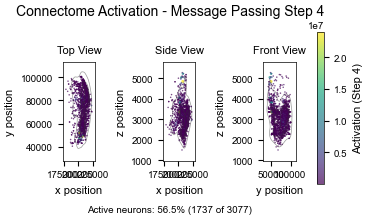

In [13]:
fig = create_nature_style_projection(propagation, neuron_position_data, step=4)
plt.show()

## Completely random connections

In [15]:
# reshuffle column post_rood_id of the dataframe connections
shuffled_connections = connections.copy()
shuffled_connections["post_root_id"] = np.random.permutation(
    connections["post_root_id"]
)
propagation2 = (
    activated_data[["root_id", "activation"]]
    .fillna(0)
    .rename(columns={"activation": "input"})
)
for i in range(num_passes):
    activation = propagate_data_with_steps(activation.copy(), shuffled_connections, i)
    propagation2 = propagation2.merge(activation, on="root_id", how="left").fillna(0)

# find percentage of non-zero values in activation_4
propagation2["activation_4"].astype(bool).sum() / len(propagation2)

0.7595060123496913

/tmp/ipykernel_136941/3499530263.py:382: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout(rect=[0, 0.15, 1, 0.95])  # [left, bottom, right, top]


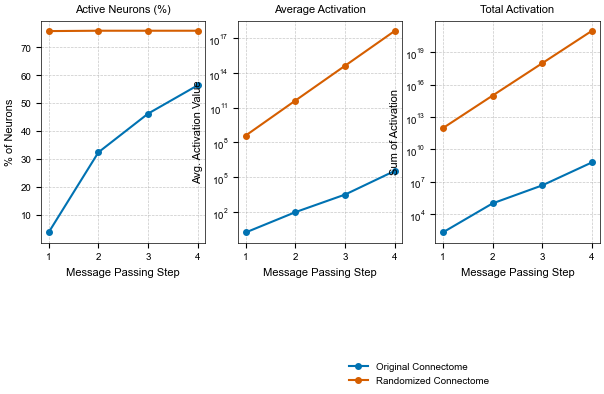

In [42]:
fig = create_activation_comparison_plot(
    [propagation, propagation2],
    ["Original Connectome", "Randomized Connectome"],
)
plt.show()

## Random connections with reduced synaptic count

In [43]:
# reshuffle column post_rood_id of the dataframe connections
random_equalized_connections = pd.read_csv(os.path.join(project_root, "new_data", "connections_random.csv"))
propagation3 = (
    activated_data[["root_id", "activation"]]
    .fillna(0)
    .rename(columns={"activation": "input"})
)
for i in range(num_passes):
    activation = propagate_data_with_steps(activation.copy(), shuffled_connections, i)
    propagation3 = propagation3.merge(activation, on="root_id", how="left").fillna(0)

# find percentage of non-zero values in activation_4
propagation3["activation_4"].astype(bool).sum() / len(propagation3)

0.7595060123496913

## Random connections within distance bins

In [45]:
# reshuffle column post_rood_id of the dataframe connections
shuffled_connections = pd.read_csv(
    os.path.join(project_root, "new_data", "connections_random3.csv"),
    dtype={
        "pre_root_id": "string",
        "post_root_id": "string",
        "syn_count": np.int32,
        },
)
shuffled_connections["weight"] = 1
propagation4 = (
    activated_data[["root_id", "activation"]]
    .fillna(0)
    .rename(columns={"activation": "input"})
)
for i in range(num_passes):
    activation = propagate_data_with_steps(activation.copy(), shuffled_connections, i)
    propagation4 = propagation4.merge(activation, on="root_id", how="left").fillna(0)

# find percentage of non-zero values in activation_4
propagation4["activation_4"].astype(bool).sum() / len(propagation4)

0.5693857653558662

/tmp/ipykernel_136941/3499530263.py:382: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout(rect=[0, 0.15, 1, 0.95])  # [left, bottom, right, top]


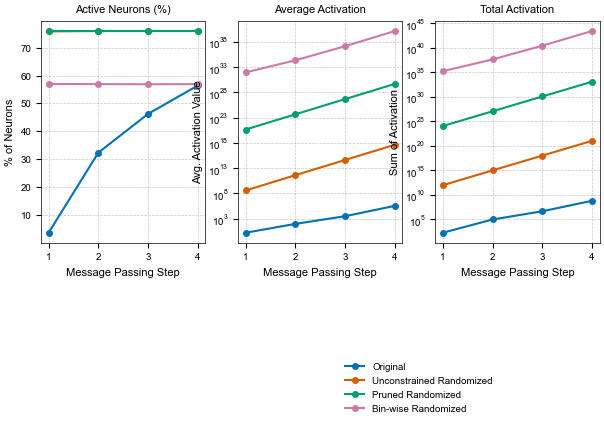

In [46]:
fig = create_activation_comparison_plot(
    [propagation, propagation2, propagation3, propagation4],
    ["Original", "Unconstrained Randomized", "Pruned Randomized", "Bin-wise Randomized"],
)
plt.show()